# Pre-process EGF Dataset

**Publication**: Song Feng et al. A Phosphoproteomics Data Resource for Systems-level Modeling of Kinase Signaling Networks

In [1]:
import pandas as pd
import numpy as np
import os
import re

import plotnine as p9
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

In [2]:
file_path = os.path.join('..', 'data_raw', 'EGFR_Phosphoproteomics_Analysis-main/phospho_proteomics_data', 'EGF_timecourse_phospho.csv')
egf_data = pd.read_csv(file_path, delimiter=';')
display(egf_data.head())

file_path = os.path.join('..', 'data_raw', 'EGFR_Phosphoproteomics_Analysis-main/phospho_proteomics_data', 'EGF_inhibitors_phospho.csv')
egf_data_inhibitors = pd.read_csv(file_path, delimiter=';')
display(egf_data_inhibitors.head())

file_path = os.path.join('..', 'data_raw', 'EGFR_Phosphoproteomics_Analysis-main/phospho_proteomics_data', 'EGF_timecourse_global.csv')
egf_data_global = pd.read_csv(file_path, delimiter=';').drop(columns=['Unnamed: 14', 'Unnamed: 15'])
display(egf_data_global.head())

,Peptide,Site,UniProt,Protein,Residue,avgRII,AScore,MCF10A_Control_R1_01,MCF10A_Control_R2_02,MCF10A_EGF_2m_R1_03,MCF10A_EGF_2m_R2_04,MCF10A_EGF_4m_R1_05,MCF10A_EGF_4m_R2_06,MCF10A_EGF_8m_R1_07,MCF10A_EGF_8m_R2_08,MCF10A_EGF_12m_R1_09,MCF10A_EGF_12m_R2_10
0,K.LGCS*PANGNSTVPSLPDNNALFVTAAQTSGLPSSVR.-,NUD4B_HUMAN-S149s,A0A024RBG1,NUD4B_HUMAN,S149s,"15,77447175","56,631","-0,577500405","-0,771579658","-0,895769868","-0,75560508","-1,180759266","-0,523763447","-0,190640437","-0,181654911","-0,257565667","-0,621440886"
1,K.GS*CFHR.I,PAL4E_HUMAN-S51s,A0A075B759,PAL4E_HUMAN,S51s,"18,44343589",1000,"-0,105586224","0,36024423","0,434935269","0,144713319","-0,375717013","-0,04657414","-0,040843824","0,062768224","-0,189391465","0,15516686"
2,K.T*AENFR.A,PAL4E_HUMAN-T32t,A0A075B759,PAL4E_HUMAN,T32t,"17,31134981",1000,"-0,4719188","0,060732761","0,232354728","0,087399966","-0,417820143","0,033339567","-0,290002323","-0,279579337","-0,224113643","-0,195858809"
3,K.DVLESGLS*PGKYY*THT*PR.R,TRGV5_HUMAN-S82sY87yT90t,A0A0B4J1U4,TRGV5_HUMAN,S82sY87yT90t,"14,86606362","8,2879","-0,306045149","-0,511528256","-0,503793419","-0,218240176","0,039579887","-0,568611815","-0,121047591","0,210533959","0,095302881","0,235452683"
4,K.SPAGLSGTPATQGLLGACS*PVR.L,SIK1B_HUMAN-S534s,A0A0B4J2F2,SIK1B_HUMAN,S534s,"15,73845037","85,186","-0,089877","-0,487156956","-0,526757727","-0,099866359","0,182324833","-0,184955362","-0,000835477","0,425625665","-0,146218358","-0,118398189"


,Peptide,Site,UniProt,Protein,Residue,AScore,Plex1_DMSO_R1,Plex1_DMSO_R2,Plex1_DMSO+EGF_R1,Plex1_DMSO+EGF_R2,...,Plex2_SHP099+EGF_R2,Plex2_SL0101_R1,Plex2_SL0101_R2,Plex2_SL0101+EGF_R1,Plex2_SL0101+EGF_R2,Plex2_UO126_R1,Plex2_UO126_R2,Plex2_UO126+EGF_R1,Plex2_UO126+EGF_R2,avgRII_plex2
0,-.MAEAPAS*PAPLSPLEVELDPEFEPQSR.P,FOXO3_HUMAN-S7s,O43524,FOXO3_HUMAN,S7s,"19,415",NaN,NaN,NaN,NaN,...,"-0,013833731","-0,141538014","-0,137822182","0,269428552","0,20353002","0,093523185","-0,149465048","-0,049730722","-0,057118566","17,39445917"
1,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N,SIR2_HUMAN-T12tS23sS25s,Q8IXJ6,SIR2_HUMAN,T12tS23sS25s,"12,631",NaN,NaN,NaN,NaN,...,"0,05081983","0,063807503","0,115832354","-0,207143766","-0,009374945","-0,022230945","-0,048955896","-0,017853693","0,035720562","17,37151142"
2,-.MAQVLHVPAPFPGT*PGPASPPAFPAK.D,KANK2_HUMAN-T14t,Q63ZY3,KANK2_HUMAN,T14t,"15,583","-0,062734354","-0,121818501","0,498665065","0,703815014",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-.MATTGT*PTADR.G,DPP9_HUMAN-T6t,Q86TI2,DPP9_HUMAN,T6t,"19,223",NaN,NaN,NaN,NaN,...,"-0,021482846","-0,162128301","-0,183889737","-0,21191669","-0,121515016","-0,070830556","-0,120463935","0,065475292","0,176038666","20,84533518"
4,-.MDPNCS*CAAGDSCTCAGSCK.C,MT2_HUMAN-S6s,P02795,MT2_HUMAN,S6s,"100,53","0,26284942","-0,105180759","-0,121256839","0,271584011",...,"-0,019064093","-0,060950979","-0,072583308","0,052200394","-0,181522296","-0,207646139","-0,0634449","0,144236614","-0,052899224","17,66620156"


C:\Users\kanto\AppData\Local\Temp\ipykernel_12464\594961703.py:10: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.


,Peptide,UniProt,Protein,avgRII,MCF10A_Control_R1_01,MCF10A_Control_R2_02,MCF10A_EGF_2m_R1_03,MCF10A_EGF_2m_R2_04,MCF10A_EGF_4m_R1_05,MCF10A_EGF_4m_R2_06,MCF10A_EGF_8m_R1_07,MCF10A_EGF_8m_R2_08,MCF10A_EGF_12m_R1_09,MCF10A_EGF_12m_R2_10
0,R.LLGIFEQNQDRK.H,A0A024RBG1,NUD4B_HUMAN,"18,70997","-0,001579174","0,0603238","-0,1579957","-0,06984359","0,05262242","0,06356125","-0,000506613","-0,005028433","0,05374689","-0,01171545"
1,N.RASGVPDR.F,A0A075B6P5,KV228_HUMAN,"17,4336","-0,4528813","0,9470623","0,8215468","-0,7531483","-0,3714897","-1,041897","0,07457455","-0,4182641","-0,3330009","0,04971916"
2,Q.ESGPGLVK.P,A0A075B6R2,HV404_HUMAN,"22,08202","-0,4432276","-0,5930111","-0,5193693","-0,6755134","-0,8139556","-0,8070243","-0,7107426","-0,4962868","-0,5644285","-0,7153336"
3,K.EFHQAGK.P,A0A0B4J2D5,GAL3B_HUMAN,"21,79930115","0,33713324","0,421877146","0,598065577","0,605367694","0,56893527","0,550228386","0,438344254","0,663422655","0,360107872","0,450241341"
4,K.EFHQAGKPIGLCCIAPVLAAK.V,A0A0B4J2D5,GAL3B_HUMAN,"21,87050663","0,644602767","0,53331766","0,441698768","0,505198245","0,604032463","0,505248184","0,702625831","0,422164145","0,526104847","0,65490942"


## Global Proteomics Data Preprocessing

In [3]:
egf_data_global = egf_data_global.drop(columns=["avgRII", "Protein"])
egf_data_global = egf_data_global.rename(columns={
    'UniProt': 'protein_id',
    'MCF10A_Control_R1_01': 'R1_0',
    'MCF10A_Control_R2_02': 'R2_0',
    'MCF10A_EGF_2m_R1_03': 'R1_2',
    'MCF10A_EGF_2m_R2_04': 'R2_2',
    'MCF10A_EGF_4m_R1_05': 'R1_4',
    'MCF10A_EGF_4m_R2_06': 'R2_4',
    'MCF10A_EGF_8m_R1_07': 'R1_8',
    'MCF10A_EGF_8m_R2_08': 'R2_8',
    'MCF10A_EGF_12m_R1_09': 'R1_12',
    'MCF10A_EGF_12m_R2_10': 'R2_12'
})

# Reorder columns so that the first columns are the desired ones.
first_cols = ['protein_id', 'Peptide']
remaining_cols = [c for c in egf_data_global.columns if c not in first_cols]
egf_data_global = egf_data_global[first_cols + remaining_cols]

# Aggregate rows with the same protein
# For numeric columns, take the median, for non-numeric ones, we take the first entry.
def select_consistent_peptide(series):
    peptides = series.dropna().unique()
    if len(peptides) == 0:
        return None
    # Sort to enforce determinism, then pick the first peptide
    return sorted(peptides)[0]

agg_dict = {}
for col in egf_data_global.columns:
    if col == 'Peptide':
        agg_dict[col] = select_consistent_peptide
    elif col in ['protein_id']:
        agg_dict[col] = 'first'
    else:
        if pd.api.types.is_numeric_dtype(egf_data_global[col]):
            agg_dict[col] = 'median'
        else:
            agg_dict[col] = 'first'

# Group by protein_id so that the same peptide is selected across all samples for that protein
egf_data_global = egf_data_global.groupby('protein_id', as_index=False, sort=False).agg(agg_dict).drop(columns=['Peptide'])

# Correct delimeter and convert to numeric
for col in egf_data_global.columns:
    if egf_data_global[col].dtype == object:
        egf_data_global[col] = egf_data_global[col].str.replace(",", ".")
        try:
            egf_data_global[col] = egf_data_global[col].astype(float)
        except ValueError:
            pass  # column might not be numeric, so skip it

# Apply min-max scaling to each sample (column)
def robust_min_max_scale(series, lower_percentile=5, upper_percentile=95):
    """
    Scales a pandas Series to [0,1] using the lower and upper quantiles.
    Values below the lower quantile are set to 0 and above the upper quantile to 1.
    
    Args:
        series (pd.Series): Input data.
        lower_percentile (float): Lower percentile (default 5).
        upper_percentile (float): Upper percentile (default 95).
    
    Returns:
        pd.Series: Scaled series.
    """
    # Compute the quantile boundaries
    q_low = np.percentile(series, lower_percentile)
    q_high = np.percentile(series, upper_percentile)
    
    # Clip values to the quantile range
    clipped = series.clip(lower=q_low, upper=q_high)
    
    # Scale to [0,1]
    scaled = (clipped - q_low) / (q_high - q_low)
    return scaled

egf_data_global.loc[:, egf_data_global.columns[1:]] = egf_data_global.loc[:, egf_data_global.columns[1:]].apply(
    lambda s: robust_min_max_scale(s, lower_percentile=5, upper_percentile=95), axis=0)

display(egf_data_global.head())

,protein_id,R1_0,R2_0,R1_2,R2_2,R1_4,R2_4,R1_8,R2_8,R1_12,R2_12
0,A0A024RBG1,0.541110,0.508543,0.349913,0.415893,0.556186,0.502382,0.521110,0.498485,0.584239,0.542566
1,A0A075B6P5,0.203524,1.000000,0.871089,0.005930,0.256907,0.000000,0.571509,0.220379,0.323930,0.585252
2,A0A075B6R2,0.210745,0.107677,0.157640,0.052508,0.000000,0.000000,0.044356,0.167871,0.168163,0.053678
3,A0A0B4J2D5,0.794477,0.730381,0.752183,0.821000,0.920527,0.785913,0.815694,0.948350,0.790442,0.863543
4,A0A0B4J2E0,0.667154,0.774324,0.418318,0.262254,0.490624,0.381523,0.331583,0.354371,0.667799,0.437411


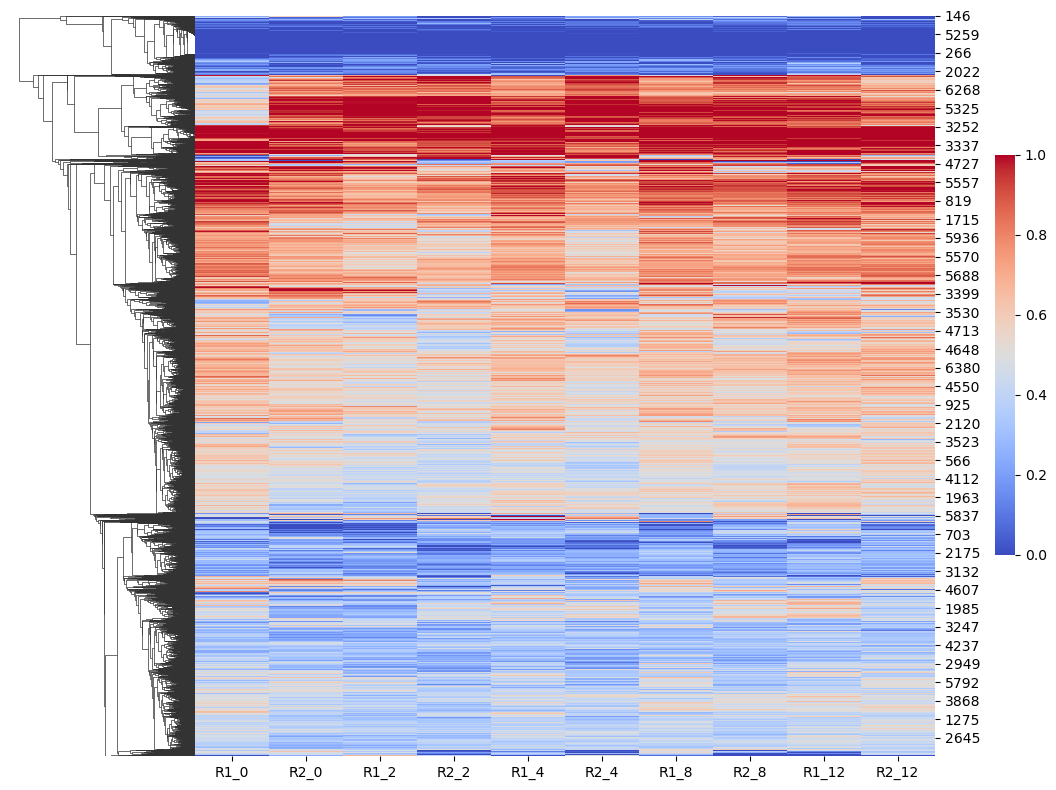

In [4]:
sns.clustermap(
    egf_data_global.iloc[:, 1:],
    cmap='coolwarm', 
    figsize=(10, 8), 
    col_cluster=False, 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0), 
    vmin=0, 
    vmax=1)
plt.show()

In [5]:
egf_data_global = egf_data_global.melt(id_vars=['protein_id'], 
                                       var_name='Condition', 
                                       value_name='Value')

# Prepend "EGF_" to Condition, creating a new column 'Drug_CL_Time'
egf_data_global['Drug_CL_Time'] = 'EGF_' + egf_data_global['Condition']

### Prepare Data for Modeling

In [6]:
# Create dictionaries with the drug doses and drug targets
egf_data_global[['Drug', 'Cell_line', 'Time']] = egf_data_global['Drug_CL_Time'].str.split('_', expand=True)

drug_dose = {'EGF': 1}  # one-hot encoded as we don't have multiple doses
cell_lines = egf_data_global['Cell_line'].unique()
drug_dose = {(drug, cell_line): dose for drug, dose in drug_dose.items() for cell_line in cell_lines}  # same drug concentration for all cell lines

drug_target = {
    'EGF': ['P01133'],
}


# Prepare X_data
unique_drug_cell_line = egf_data_global[['Drug', 'Cell_line']].drop_duplicates().sort_values(by=['Drug', 'Cell_line'])
multiindex = pd.MultiIndex.from_frame(unique_drug_cell_line)
X_data = pd.DataFrame(index=multiindex)

unique_drugs = egf_data_global['Drug'].unique()
for drug in unique_drugs:
    X_data[drug] = 0.0

for (drug, cell_line), dose in drug_dose.items():
    if (drug, cell_line) in X_data.index:
        X_data.loc[(drug, cell_line), drug] = dose

X_data.index = X_data.index.map('_'.join)
X_data.index.name = 'Drug_CL'

# Prepare X_drug
unique_targets = sorted(set(target for targets in drug_target.values() for target in targets))
X_drug = pd.DataFrame(0, index=unique_targets, columns=unique_drugs)

for drug, targets in drug_target.items():
    for target in targets:
        if target in X_drug.index:
            X_drug.loc[target, drug] = 1


# Prepare X_cell
X_cell = pd.DataFrame(index=multiindex)

unique_cell_lines = egf_data_global['Cell_line'].unique()
for cell_line in unique_cell_lines:
    X_cell[cell_line] = 0

for drug, cell_line in unique_drug_cell_line.itertuples(index=False):
    X_cell.loc[(drug, cell_line), cell_line] = 1

X_cell.index = X_cell.index.map('_'.join)
X_cell.index.name = 'Drug_CL'


# Prepare y_data
y_data = egf_data_global.pivot(index=['Drug', 'Cell_line', 'Time'], columns='protein_id', values='Value')
y_data.reset_index(inplace=True)
y_data['Drug_CL_Time'] = y_data[['Drug', 'Cell_line', 'Time']].astype(str).agg('_'.join, axis=1)
y_data.set_index('Drug_CL_Time', inplace=True)
y_data.drop(columns=['Drug', 'Cell_line', 'Time'], inplace=True)


# Prepare nodes_sites_map
unique_proteins = egf_data_global['protein_id'].unique()
unique_sites = egf_data_global['protein_id'].unique()

nodes_sites_map = pd.DataFrame(0, index=unique_sites, columns=unique_proteins)

for _, row in egf_data_global.iterrows():
    site = row['protein_id']
    protein = row['protein_id']
    if site in nodes_sites_map.index and protein in nodes_sites_map.columns:
        nodes_sites_map.loc[site, protein] = 1

# Sort and match index of nodes_sites_map with y_data
nodes_sites_map = nodes_sites_map.sort_index()
non_overlapping_values = set(nodes_sites_map.index).difference(y_data.columns)
nodes_sites_map = nodes_sites_map.drop(index=non_overlapping_values)

In [7]:
# Order Data
y_data = y_data[sorted(y_data.columns)]
temp = y_data.index.to_series().str.split('_', expand=True)
temp.columns = ['Drug', 'Cell_line', 'Time']
temp['Time'] = temp['Time'].astype(int)
y_data = y_data.loc[temp.sort_values(by=['Time','Drug','Cell_line']).index]

X_data = X_data.sort_index()
X_data = X_data[sorted(X_data.columns)]

X_cell = X_cell.sort_index()
X_cell = X_cell[sorted(X_cell.columns)]

X_drug = X_drug.sort_index()
X_drug = X_drug[sorted(X_drug.columns)]

nodes_sites_map = nodes_sites_map.sort_index()
nodes_sites_map = nodes_sites_map[sorted(nodes_sites_map.columns)]

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,EGF
Drug_CL,
EGF_R1,1.0
EGF_R2,1.0


(2, 1)


,EGF
P01133,1


(1, 1)


,R1,R2
Drug_CL,,
EGF_R1,1,0
EGF_R2,0,1


(2, 2)


protein_id,A0A024RBG1,A0A075B6P5,A0A075B6R2,A0A0B4J2D5,A0A0B4J2E0,A0A0U1RRE5,A0A1B0GTR4,A0AV96,A0AVF1,A0AVT1,...,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6Y0,Q9Y6Y8
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,0.541110,0.203524,0.210745,0.794477,0.667154,0.285080,0.719346,0.717081,0.195533,0.721174,...,0.678203,0.702190,0.767909,0.801859,0.266573,0.832218,0.377339,0.710756,0.394409,0.521492
EGF_R2_0,0.508543,1.000000,0.107677,0.730381,0.774324,0.129434,0.465436,0.619976,0.279435,0.609398,...,0.526974,0.483427,1.000000,0.599204,0.325914,0.627688,0.319238,0.556564,0.247561,0.504886
EGF_R1_2,0.349913,0.871089,0.157640,0.752183,0.418318,0.314247,0.688617,0.558383,0.189513,0.512118,...,0.489752,0.455707,0.999773,0.489183,0.351405,0.576788,0.264552,0.573503,0.353868,0.419060
EGF_R2_2,0.415893,0.005930,0.052508,0.821000,0.262254,0.311471,0.823879,0.559626,0.236862,0.530630,...,0.611417,0.589278,0.222968,0.448628,0.231461,0.490483,0.363396,0.491970,0.356028,0.304138
EGF_R1_4,0.556186,0.256907,0.000000,0.920527,0.490624,0.551019,0.889067,0.465743,0.225017,0.732355,...,0.649566,0.643809,0.237078,0.585056,0.228541,0.693988,0.397868,0.627888,0.293242,0.457229


(10, 6559)


,A0A024RBG1,A0A075B6P5,A0A075B6R2,A0A0B4J2D5,A0A0B4J2E0,A0A0U1RRE5,A0A1B0GTR4,A0AV96,A0AVF1,A0AVT1,...,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X3,Q9Y6X4,Q9Y6Y0,Q9Y6Y8
A0A024RBG1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A075B6P5,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A075B6R2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J2D5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0A0B4J2E0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(6559, 6559)


### Export Data

In [8]:
y_data.to_csv('../data/egf_y_global.csv', index=True)
X_data.to_csv('../data/egf_x_global.csv', index=True)
X_cell.to_csv('../data/egf_xcell_global.csv', index=True)
X_drug.to_csv('../data/egf_xdrug_global.csv', index=True)
nodes_sites_map.to_csv('../data/egf_nodes_sites_map_global.csv', index=True)

## Phosphoproteomics Data Preprocessing

In [9]:
egf_data = egf_data.drop(columns=["Site"])
egf_data["Protein"] = egf_data["Protein"].str.replace("_HUMAN", "", regex=False)
egf_data["Residue_split"] = egf_data["Residue"].apply(lambda x: re.findall(r'([A-Z]\d+[a-z])', x))
egf_data = egf_data.explode("Residue_split").reset_index(drop=True)
egf_data = egf_data.drop(columns=["Residue"]).rename(columns={"Residue_split": "Residue"})
egf_data["site_id"] = egf_data["Protein"] + ":" + egf_data["UniProt"] + ":" + egf_data["Residue"]
egf_data = egf_data.rename(columns={
    'Peptide': 'modified_peptide_sequence',
    'Residue': 'phosphosite',
    'Protein': 'gene_id',
    'UniProt': 'protein_id'
})

# Reorder columns so that the first columns are the desired ones.
first_cols = ['site_id', 'gene_id', 'protein_id', 'phosphosite', 'modified_peptide_sequence']
remaining_cols = [c for c in egf_data.columns if c not in first_cols]
egf_data = egf_data[first_cols + remaining_cols]

# Aggregate rows with the same site_id
# For numeric columns, take the median, for non-numeric ones, we take the first entry.
agg_dict = {}
for col in egf_data.columns:
    if col in first_cols:
        agg_dict[col] = 'first'
    else:
        if pd.api.types.is_numeric_dtype(egf_data[col]):
            agg_dict[col] = 'median'
        else:
            agg_dict[col] = 'first'
            
egf_data = egf_data.groupby('site_id', as_index=False, sort=False).agg(agg_dict)

display(egf_data.head())

,site_id,gene_id,protein_id,phosphosite,modified_peptide_sequence,avgRII,AScore,MCF10A_Control_R1_01,MCF10A_Control_R2_02,MCF10A_EGF_2m_R1_03,MCF10A_EGF_2m_R2_04,MCF10A_EGF_4m_R1_05,MCF10A_EGF_4m_R2_06,MCF10A_EGF_8m_R1_07,MCF10A_EGF_8m_R2_08,MCF10A_EGF_12m_R1_09,MCF10A_EGF_12m_R2_10
0,NUD4B:A0A024RBG1:S149s,NUD4B,A0A024RBG1,S149s,K.LGCS*PANGNSTVPSLPDNNALFVTAAQTSGLPSSVR.-,"15,77447175","56,631","-0,577500405","-0,771579658","-0,895769868","-0,75560508","-1,180759266","-0,523763447","-0,190640437","-0,181654911","-0,257565667","-0,621440886"
1,PAL4E:A0A075B759:S51s,PAL4E,A0A075B759,S51s,K.GS*CFHR.I,"18,44343589",1000,"-0,105586224","0,36024423","0,434935269","0,144713319","-0,375717013","-0,04657414","-0,040843824","0,062768224","-0,189391465","0,15516686"
2,PAL4E:A0A075B759:T32t,PAL4E,A0A075B759,T32t,K.T*AENFR.A,"17,31134981",1000,"-0,4719188","0,060732761","0,232354728","0,087399966","-0,417820143","0,033339567","-0,290002323","-0,279579337","-0,224113643","-0,195858809"
3,TRGV5:A0A0B4J1U4:S82s,TRGV5,A0A0B4J1U4,S82s,K.DVLESGLS*PGKYY*THT*PR.R,"14,86606362","8,2879","-0,306045149","-0,511528256","-0,503793419","-0,218240176","0,039579887","-0,568611815","-0,121047591","0,210533959","0,095302881","0,235452683"
4,TRGV5:A0A0B4J1U4:Y87y,TRGV5,A0A0B4J1U4,Y87y,K.DVLESGLS*PGKYY*THT*PR.R,"14,86606362","8,2879","-0,306045149","-0,511528256","-0,503793419","-0,218240176","0,039579887","-0,568611815","-0,121047591","0,210533959","0,095302881","0,235452683"


In [10]:
# Split the DataFrame into map_protein and phospho_data
map_protein = egf_data[['site_id', 'gene_id', 'protein_id', 'phosphosite', 'modified_peptide_sequence']]
phospho_data = egf_data[['site_id', 'MCF10A_Control_R1_01', 'MCF10A_Control_R2_02', 'MCF10A_EGF_2m_R1_03', 'MCF10A_EGF_2m_R2_04', 'MCF10A_EGF_4m_R1_05', 'MCF10A_EGF_4m_R2_06', 'MCF10A_EGF_8m_R1_07', 'MCF10A_EGF_8m_R2_08', 'MCF10A_EGF_12m_R1_09', 'MCF10A_EGF_12m_R2_10']].copy()
phospho_data = phospho_data.rename(columns={
    'MCF10A_Control_R1_01': 'R1_0',
    'MCF10A_Control_R2_02': 'R2_0',
    'MCF10A_EGF_2m_R1_03': 'R1_2',
    'MCF10A_EGF_2m_R2_04': 'R2_2',
    'MCF10A_EGF_4m_R1_05': 'R1_4',
    'MCF10A_EGF_4m_R2_06': 'R2_4',
    'MCF10A_EGF_8m_R1_07': 'R1_8',
    'MCF10A_EGF_8m_R2_08': 'R2_8',
    'MCF10A_EGF_12m_R1_09': 'R1_12',
    'MCF10A_EGF_12m_R2_10': 'R2_12',
})

# Long-transform phospho_data: melt all measurement columns; assume the first column is 'site_id'
phospho_data = phospho_data.melt(id_vars=['site_id'], 
                            var_name='Condition', 
                            value_name='Value')

# Prepend "EGF_" to Condition, creating a new column 'Drug_CL_Time'
phospho_data['Drug_CL_Time'] = 'EGF_' + phospho_data['Condition']

display(map_protein.head())
display(phospho_data.head())

,site_id,gene_id,protein_id,phosphosite,modified_peptide_sequence
0,NUD4B:A0A024RBG1:S149s,NUD4B,A0A024RBG1,S149s,K.LGCS*PANGNSTVPSLPDNNALFVTAAQTSGLPSSVR.-
1,PAL4E:A0A075B759:S51s,PAL4E,A0A075B759,S51s,K.GS*CFHR.I
2,PAL4E:A0A075B759:T32t,PAL4E,A0A075B759,T32t,K.T*AENFR.A
3,TRGV5:A0A0B4J1U4:S82s,TRGV5,A0A0B4J1U4,S82s,K.DVLESGLS*PGKYY*THT*PR.R
4,TRGV5:A0A0B4J1U4:Y87y,TRGV5,A0A0B4J1U4,Y87y,K.DVLESGLS*PGKYY*THT*PR.R


,site_id,Condition,Value,Drug_CL_Time
0,NUD4B:A0A024RBG1:S149s,R1_0,"-0,577500405",EGF_R1_0
1,PAL4E:A0A075B759:S51s,R1_0,"-0,105586224",EGF_R1_0
2,PAL4E:A0A075B759:T32t,R1_0,"-0,4719188",EGF_R1_0
3,TRGV5:A0A0B4J1U4:S82s,R1_0,"-0,306045149",EGF_R1_0
4,TRGV5:A0A0B4J1U4:Y87y,R1_0,"-0,306045149",EGF_R1_0


Check overlap of proteins with PKN and filter out nodes in the data that are not in the PKN.

Number of unique proteins in net: 6064
Number of unique protein_ids in map_protein: 5616


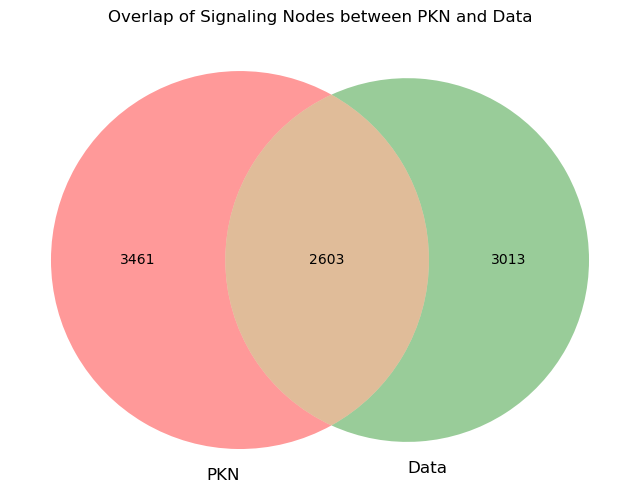

In [11]:
net = pd.read_csv('../data/pkn_signaling.tsv', sep = '\t', index_col = False)
proteins_net = pd.concat([net['source'], net['target']], ignore_index=True).unique().tolist()
print("Number of unique proteins in net:", len(proteins_net))

proteins_map = map_protein['protein_id'].unique().tolist()
print("Number of unique protein_ids in map_protein:", len(proteins_map))

set_net = set(proteins_net)
set_map = set(proteins_map)

plt.figure(figsize=(8, 8))
venn_diagram = venn2([set_net, set_map], set_labels=('PKN', 'Data'))
plt.title("Overlap of Signaling Nodes between PKN and Data")
plt.show()

In [12]:
# Filter out proteins that are not in the PKN from map_protein
map_protein = map_protein[map_protein['protein_id'].isin(set_net)]
print("Filtered map_protein shape:", map_protein.shape)

# Filter also the corresponding phosphosites
valid_site_ids = map_protein['site_id'].unique().tolist()
print("Number of valid site_ids in filtered map_protein:", len(valid_site_ids))

phospho_data = phospho_data[phospho_data['site_id'].isin(valid_site_ids)]
print("Filtered phospho_data shape:", phospho_data.shape)

Filtered map_protein shape: (19065, 5)
Number of valid site_ids in filtered map_protein: 19065
Filtered phospho_data shape: (190650, 4)


In [13]:
# Widen data
phospho_data_wide = phospho_data.pivot(index='Drug_CL_Time', columns='site_id', values='Value')
phospho_data_wide = phospho_data_wide.reindex(sorted(phospho_data_wide.columns), axis=1)

# Sort the row index, which has format "EGF_Rx_y"
def sort_key(item):
    parts = item.split('_')
    time_val = int(parts[2])
    r_number = int(parts[1][1:])  # skip the letter "R"
    return (time_val, r_number)

sorted_rows = sorted(phospho_data_wide.index, key=sort_key)
phospho_data_wide = phospho_data_wide.loc[sorted_rows]
phospho_data_wide.index.name = "Drug_CL_Time"

display(phospho_data_wide.head())

site_id,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S212s,1433S:P31947:S248s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,"-0,030478801","-0,657851885","-0,246736006","0,077427647","-0,657851885","0,462425735","0,277434344","0,729609306","0,342797017","0,070812348",...,"-0,363885025","-1,527132316","-1,502397043","-1,001603375","-0,658777884","0,035326059","-1,063139147","-1,795758402","-2,589777375","-1,254588935"
EGF_R2_0,"-0,895855293","-0,831303772","-0,335640729","-0,352438577","-0,831303772","-0,258491921","-0,361850496","0,125242331","-0,454482381","-0,287467129",...,"-0,045587949","-1,714333499","-1,979430118","-1,257025782","-1,126934663","0,032173135","-1,271806191","-2,007758398","-2,516157845","-1,335665171"
EGF_R1_2,"-1,141777928","-0,457876717","-0,540829826","-0,032202021","-0,457876717","-0,250547118","-0,622722398","0,090442199","-0,118989685","-0,154651009",...,"-0,355033781","-1,7425204","-1,768622243","-1,564773052","-1,162621638","0,518072273","-1,181068808","-2,107800307","-2,65566385","-1,195929987"
EGF_R2_2,"-0,3329345","-0,265398627","-0,215250892","0,190632173","-0,265398627","0,563662082","0,074831","0,987147807","0,674478584","0,045945873",...,"-0,547264596","-0,969857462","-1,273526951","-1,020153671","-0,925320421","-0,161955453","-1,336020137","-1,793862661","-2,341803249","-0,984555919"
EGF_R1_4,"-0,297576586","-0,007715845","-0,170563592","0,046843059","-0,007715845","0,434181003","0,334414277","0,88000252","0,389007559","0,008397737",...,"-1,120297574","-1,350230939","-1,428485497","-0,924242918","-0,833852501","-0,087477961","-1,260145933","-1,440121431","-1,283719061","-1,306304603"


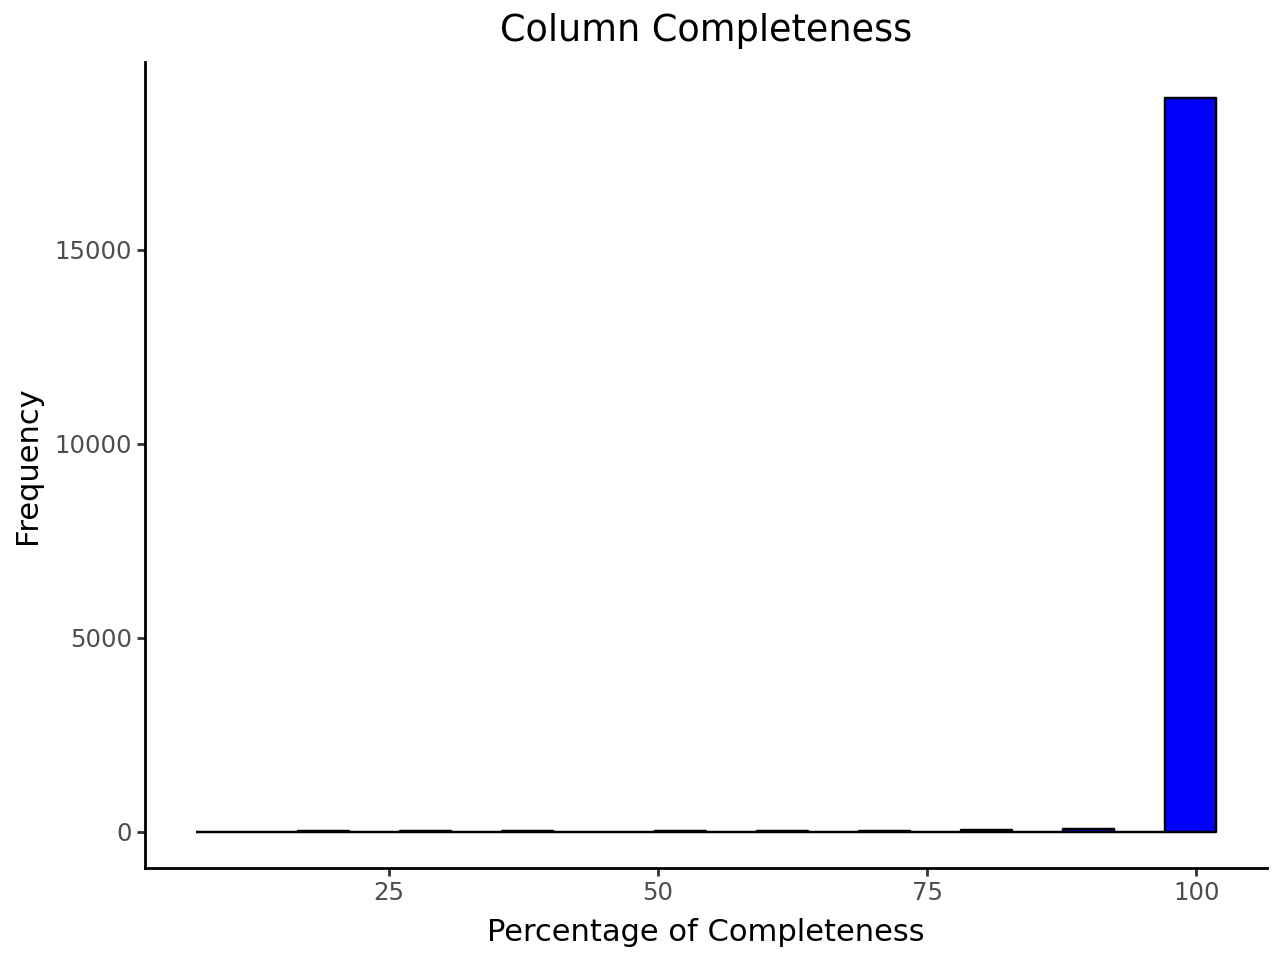

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


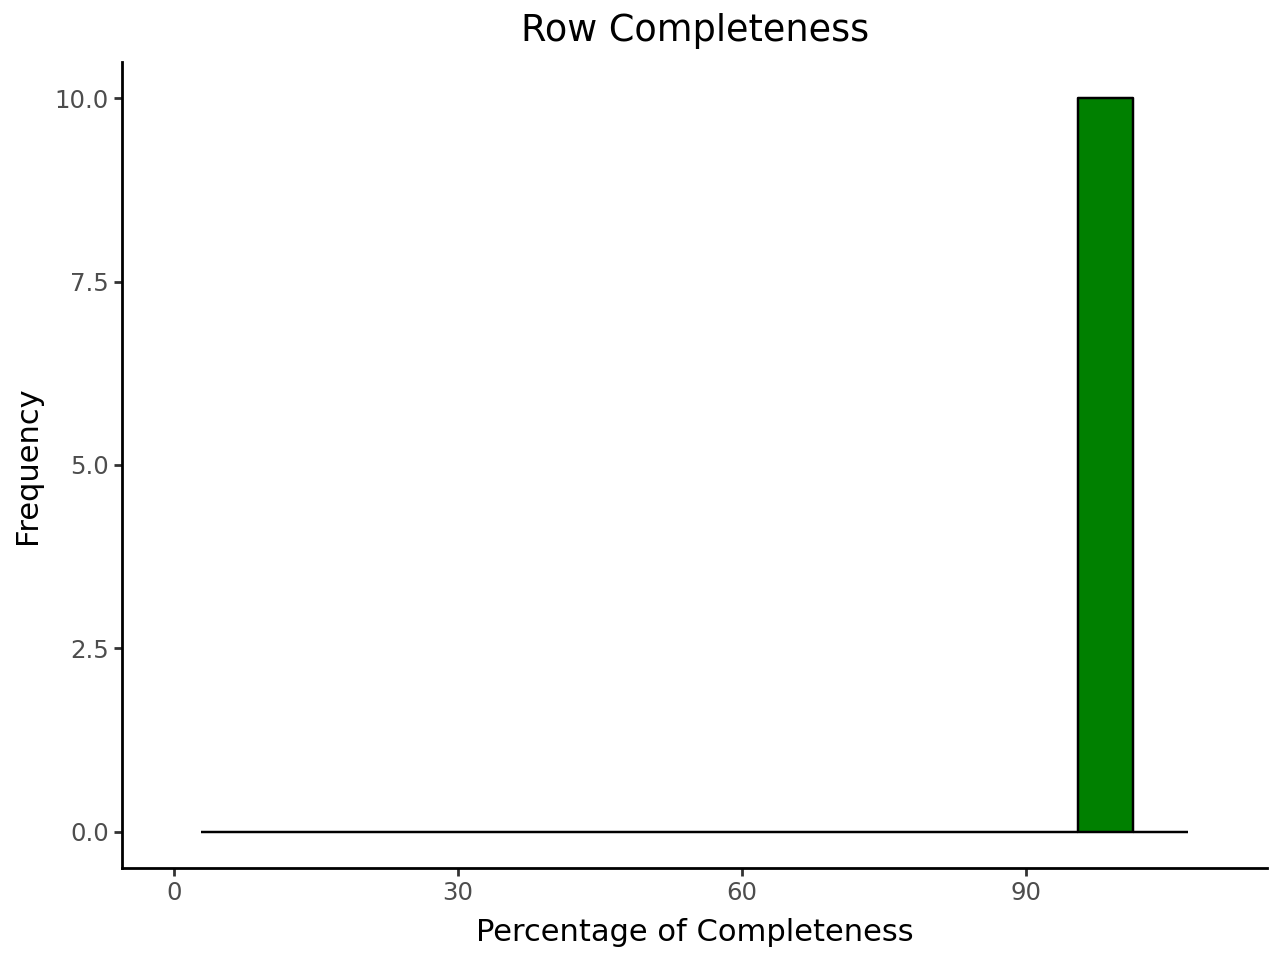

In [14]:
# Calculate the percentage of completeness across rows and columns (excluding Cell_line, Drug, and Time)
column_completeness = phospho_data_wide.notna().mean() * 100
row_completeness = phospho_data_wide.notna().mean(axis=1) * 100

column_completeness_df = pd.DataFrame({'Completeness': column_completeness})
row_completeness_df = pd.DataFrame({'Completeness': row_completeness})

# Histogram for column completeness
p1 = (p9.ggplot(column_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='blue', color='black') +
      p9.labs(title='Column Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      p9.theme_classic())

# Histogram for row completeness
p2 = (p9.ggplot(row_completeness_df, p9.aes(x='Completeness')) +
      p9.geom_histogram(bins=20, fill='green', color='black') +
      p9.labs(title='Row Completeness',
           x='Percentage of Completeness',
           y='Frequency') +
      p9.xlim(0, 110) +
      p9.theme_classic())

p1.show()
p2.show()

Plot relations between proteins, peptides and phosphosites.

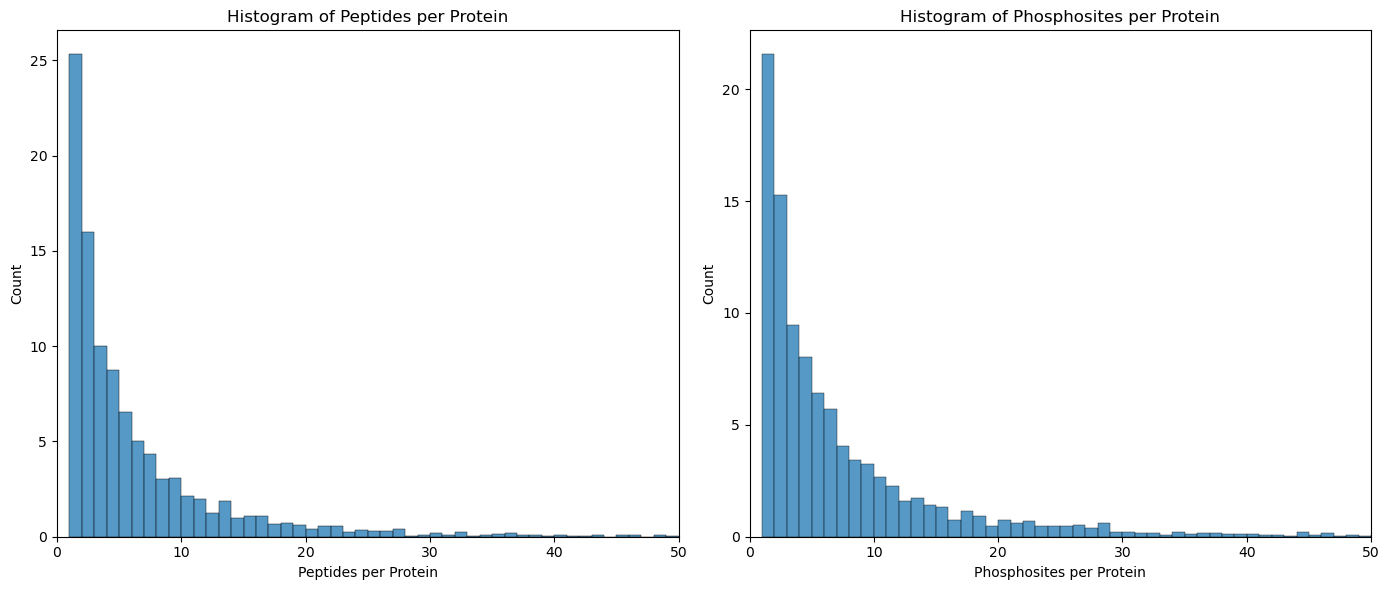

In [15]:
protein_aggregates = map_protein.groupby('protein_id').agg(
    peptides_per_protein=('modified_peptide_sequence', 'nunique'),
    phosphosites_per_protein=('phosphosite', 'nunique')
).reset_index()

# Plot histograms for peptides per protein and phosphosites per protein
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(protein_aggregates['peptides_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Peptides per Protein')
plt.xlabel('Peptides per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.subplot(1, 2, 2)
sns.histplot(protein_aggregates['phosphosites_per_protein'], binwidth=1, stat='percent')
plt.title('Histogram of Phosphosites per Protein')
plt.xlabel('Phosphosites per Protein')
plt.ylabel('Count')
plt.xlim(0, 50)

plt.tight_layout()
plt.show()

### Prepare Data for Modeling

Based on the phospho_data create the input datasets `X`, `X_drug` and `X_cell` as well as the target dataset `y`. Based on the map_protein create the nodes_sites_map dataset.

In [16]:
# Create dictionaries with the drug doses and drug targets
for col in phospho_data.columns:
    if phospho_data[col].dtype == object:
        phospho_data[col] = phospho_data[col].str.replace(",", ".")
        try:
            phospho_data[col] = phospho_data[col].astype(float)
        except ValueError:
            pass  # column might not be numeric, so skip it
phospho_data[['Drug', 'Cell_line', 'Time']] = phospho_data['Drug_CL_Time'].str.split('_', expand=True)

drug_dose = {'EGF': 1}  # one-hot encoded as we don't have multiple doses
cell_lines = phospho_data['Cell_line'].unique()
drug_dose = {(drug, cell_line): dose for drug, dose in drug_dose.items() for cell_line in cell_lines}  # same drug concentration for all cell lines

drug_target = {
    'EGF': ['P01133'],
}


# Prepare X_data
unique_drug_cell_line = phospho_data[['Drug', 'Cell_line']].drop_duplicates().sort_values(by=['Drug', 'Cell_line'])
multiindex = pd.MultiIndex.from_frame(unique_drug_cell_line)
X_data = pd.DataFrame(index=multiindex)

unique_drugs = phospho_data['Drug'].unique()
for drug in unique_drugs:
    X_data[drug] = 0.0

for (drug, cell_line), dose in drug_dose.items():
    if (drug, cell_line) in X_data.index:
        X_data.loc[(drug, cell_line), drug] = dose

X_data.index = X_data.index.map('_'.join)
X_data.index.name = 'Drug_CL'

# Prepare X_drug
unique_targets = sorted(set(target for targets in drug_target.values() for target in targets))
X_drug = pd.DataFrame(0, index=unique_targets, columns=unique_drugs)

for drug, targets in drug_target.items():
    for target in targets:
        if target in X_drug.index:
            X_drug.loc[target, drug] = 1


# Prepare X_cell
X_cell = pd.DataFrame(index=multiindex)

unique_cell_lines = phospho_data['Cell_line'].unique()
for cell_line in unique_cell_lines:
    X_cell[cell_line] = 0

for drug, cell_line in unique_drug_cell_line.itertuples(index=False):
    X_cell.loc[(drug, cell_line), cell_line] = 1

X_cell.index = X_cell.index.map('_'.join)
X_cell.index.name = 'Drug_CL'


# Prepare y_data
y_data = phospho_data.pivot(index=['Drug', 'Cell_line', 'Time'], columns='site_id', values='Value')
y_data.reset_index(inplace=True)
y_data['Drug_CL_Time'] = y_data[['Drug', 'Cell_line', 'Time']].astype(str).agg('_'.join, axis=1)
y_data.set_index('Drug_CL_Time', inplace=True)
y_data.drop(columns=['Drug', 'Cell_line', 'Time'], inplace=True)


# Prepare nodes_sites_map
unique_proteins = map_protein['protein_id'].unique()
unique_sites = map_protein['site_id'].unique()

nodes_sites_map = pd.DataFrame(0, index=unique_sites, columns=unique_proteins)

for _, row in map_protein.iterrows():
    site = row['site_id']
    protein = row['protein_id']
    if site in nodes_sites_map.index and protein in nodes_sites_map.columns:
        nodes_sites_map.loc[site, protein] = 1

# Sort and match index of nodes_sites_map with y_data
nodes_sites_map = nodes_sites_map.sort_index()
non_overlapping_values = set(nodes_sites_map.index).difference(y_data.columns)
nodes_sites_map = nodes_sites_map.drop(index=non_overlapping_values)

In [17]:
# Order Data
y_data = y_data[sorted(y_data.columns)]
temp = y_data.index.to_series().str.split('_', expand=True)
temp.columns = ['Drug', 'Cell_line', 'Time']
temp['Time'] = temp['Time'].astype(int)
y_data = y_data.loc[temp.sort_values(by=['Time','Drug','Cell_line']).index]

X_data = X_data.sort_index()
X_data = X_data[sorted(X_data.columns)]

X_cell = X_cell.sort_index()
X_cell = X_cell[sorted(X_cell.columns)]

X_drug = X_drug.sort_index()
X_drug = X_drug[sorted(X_drug.columns)]

nodes_sites_map = nodes_sites_map.sort_index()
nodes_sites_map = nodes_sites_map[sorted(nodes_sites_map.columns)]

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,EGF
Drug_CL,
EGF_R1,1.0
EGF_R2,1.0


(2, 1)


,EGF
P01133,1


(1, 1)


,R1,R2
Drug_CL,,
EGF_R1,1,0
EGF_R2,0,1


(2, 2)


site_id,1433E:P62258:S117s,1433E:P62258:S148s,1433E:P62258:S210s,1433E:P62258:S233s,1433E:P62258:Y152y,1433F:Q04917:S145s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S212s,1433S:P31947:S248s,...,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S288s,ZYX:Q15942:S290s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.030479,-0.657852,-0.246736,0.077428,-0.657852,0.462426,0.277434,0.729609,0.342797,0.070812,...,-0.363885,-1.527132,-1.502397,-1.001603,-0.658778,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.895855,-0.831304,-0.335641,-0.352439,-0.831304,-0.258492,-0.361850,0.125242,-0.454482,-0.287467,...,-0.045588,-1.714333,-1.979430,-1.257026,-1.126935,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-1.141778,-0.457877,-0.540830,-0.032202,-0.457877,-0.250547,-0.622722,0.090442,-0.118990,-0.154651,...,-0.355034,-1.742520,-1.768622,-1.564773,-1.162622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,-0.332935,-0.265399,-0.215251,0.190632,-0.265399,0.563662,0.074831,0.987148,0.674479,0.045946,...,-0.547265,-0.969857,-1.273527,-1.020154,-0.925320,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,-0.297577,-0.007716,-0.170564,0.046843,-0.007716,0.434181,0.334414,0.880003,0.389008,0.008398,...,-1.120298,-1.350231,-1.428485,-0.924243,-0.833853,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


(10, 19065)


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S117s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S148s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:Y152y,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(19065, 2603)


### Export Data

In [18]:
y_data.to_csv('../data/egf_y.csv', index=True)
X_data.to_csv('../data/egf_x.csv', index=True)
X_cell.to_csv('../data/egf_xcell.csv', index=True)
X_drug.to_csv('../data/egf_xdrug.csv', index=True)
nodes_sites_map.to_csv('../data/egf_nodes_sites_map.csv', index=True)

## Inhibitors Phosphoproteomics Data Preprocessing

In [19]:
egf_data_inhibitors = egf_data_inhibitors.drop(columns=["Site"])
egf_data_inhibitors["Protein"] = egf_data_inhibitors["Protein"].str.replace("_HUMAN", "", regex=False)
egf_data_inhibitors["Residue_split"] = egf_data_inhibitors["Residue"].apply(lambda x: re.findall(r'([A-Z]\d+[a-z])', x))
egf_data_inhibitors = egf_data_inhibitors.explode("Residue_split").reset_index(drop=True)
egf_data_inhibitors = egf_data_inhibitors.drop(columns=["Residue"]).rename(columns={"Residue_split": "Residue"})
egf_data_inhibitors["site_id"] = egf_data_inhibitors["Protein"] + ":" + egf_data_inhibitors["UniProt"] + ":" + egf_data_inhibitors["Residue"]
egf_data_inhibitors = egf_data_inhibitors.rename(columns={
    'Peptide': 'modified_peptide_sequence',
    'Residue': 'phosphosite',
    'Protein': 'gene_id',
    'UniProt': 'protein_id'
})

# Reorder columns so that the first columns are the desired ones.
first_cols = ['site_id', 'gene_id', 'protein_id', 'phosphosite', 'modified_peptide_sequence']
remaining_cols = [c for c in egf_data_inhibitors.columns if c not in first_cols]
egf_data_inhibitors = egf_data_inhibitors[first_cols + remaining_cols]

# Aggregate rows with the same site_id
# For numeric columns, take the median, for non-numeric ones, we take the first entry.
agg_dict = {}
for col in egf_data_inhibitors.columns:
    if col in first_cols:
        agg_dict[col] = 'first'
    else:
        if pd.api.types.is_numeric_dtype(egf_data_inhibitors[col]):
            agg_dict[col] = 'median'
        else:
            agg_dict[col] = 'first'
            
egf_data_inhibitors = egf_data_inhibitors.groupby('site_id', as_index=False, sort=False).agg(agg_dict)

display(egf_data_inhibitors.head())

,site_id,gene_id,protein_id,phosphosite,modified_peptide_sequence,AScore,Plex1_DMSO_R1,Plex1_DMSO_R2,Plex1_DMSO+EGF_R1,Plex1_DMSO+EGF_R2,...,Plex2_SHP099+EGF_R2,Plex2_SL0101_R1,Plex2_SL0101_R2,Plex2_SL0101+EGF_R1,Plex2_SL0101+EGF_R2,Plex2_UO126_R1,Plex2_UO126_R2,Plex2_UO126+EGF_R1,Plex2_UO126+EGF_R2,avgRII_plex2
0,FOXO3:O43524:S7s,FOXO3,O43524,S7s,-.MAEAPAS*PAPLSPLEVELDPEFEPQSR.P,"19,415",None,None,None,None,...,"-0,013833731","-0,141538014","-0,137822182","0,269428552","0,20353002","0,093523185","-0,149465048","-0,049730722","-0,057118566","17,39445917"
1,SIR2:Q8IXJ6:T12t,SIR2,Q8IXJ6,T12t,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N,"12,631",None,None,None,None,...,"0,05081983","0,063807503","0,115832354","-0,207143766","-0,009374945","-0,022230945","-0,048955896","-0,017853693","0,035720562","17,37151142"
2,SIR2:Q8IXJ6:S23s,SIR2,Q8IXJ6,S23s,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N,"12,631",None,None,None,None,...,"0,05081983","0,063807503","0,115832354","-0,207143766","-0,009374945","-0,022230945","-0,048955896","-0,017853693","0,035720562","17,37151142"
3,SIR2:Q8IXJ6:S25s,SIR2,Q8IXJ6,S25s,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N,"12,631","-0,829874874","-0,370931792","-0,794486077","-1,653949349",...,"0,05081983","0,063807503","0,115832354","-0,207143766","-0,009374945","-0,022230945","-0,048955896","-0,017853693","0,035720562","17,37151142"
4,KANK2:Q63ZY3:T14t,KANK2,Q63ZY3,T14t,-.MAQVLHVPAPFPGT*PGPASPPAFPAK.D,"15,583","-0,062734354","-0,121818501","0,498665065","0,703815014",...,None,None,None,None,None,None,None,None,None,None


In [20]:
# Split the DataFrame into map_protein and phospho_data
map_protein_inhibitors = egf_data_inhibitors[['site_id', 'gene_id', 'protein_id', 'phosphosite', 'modified_peptide_sequence']]
phospho_data_inhibitors = egf_data_inhibitors[['site_id', 'Plex1_DMSO_R1', 'Plex1_DMSO_R2', 'Plex1_DMSO+EGF_R1', 'Plex1_DMSO+EGF_R2', 'Plex1_LY294002_R1', 'Plex1_LY294002_R2', 'Plex1_LY294002+EGF_R1', 'Plex1_LY294002+EGF_R2', 'Plex1_SHP099_R1', 'Plex1_SHP099_R2', 'Plex1_SHP099+EGF_R1', 'Plex1_SHP099+EGF_R2', 'Plex1_UO126_R1', 'Plex1_UO126_R2',
                                               'Plex1_UO126+EGF_R1', 'Plex1_UO126+EGF_R2', 'avgRII_plex1', 'Plex2_DMSO_R1', 'Plex2_DMSO_R2', 'Plex2_DMSO+EGF_R1', 'Plex2_DMSO+EGF_R2', 'Plex2_SHP099_R1', 'Plex2_SHP099_R2', 'Plex2_SHP099+EGF_R1', 'Plex2_SHP099+EGF_R2', 'Plex2_SL0101_R1', 'Plex2_SL0101_R2', 'Plex2_SL0101+EGF_R1', 'Plex2_SL0101+EGF_R2',
                                               'Plex2_UO126_R1', 'Plex2_UO126_R2', 'Plex2_UO126+EGF_R1', 'Plex2_UO126+EGF_R2']].copy()
phospho_data_inhibitors = phospho_data_inhibitors.rename(columns={
    'Plex1_DMSO_R1': 'Plex1_R1_DMSO_12',
    'Plex1_DMSO_R2': 'Plex1_R2_DMSO_12',
    'Plex1_DMSO+EGF_R1': 'Plex1_R1_DMSO-EGF_12', 
    'Plex1_DMSO+EGF_R2': 'Plex1_R2_DMSO-EGF_12', 
    'Plex1_LY294002_R1': 'Plex1_R1_LY294002_12',
    'Plex1_LY294002_R2': 'Plex1_R2_LY294002_12', 
    'Plex1_LY294002+EGF_R1': 'Plex1_R1_LY294002-EGF_12', 
    'Plex1_LY294002+EGF_R2': 'Plex1_R2_LY294002-EGF_12',
    'Plex1_SHP099_R1': 'Plex1_R1_SHP099_12', 
    'Plex1_SHP099_R2': 'Plex1_R2_SHP099_12', 
    'Plex1_SHP099+EGF_R1': 'Plex1_R1_SHP099-EGF_12',
    'Plex1_SHP099+EGF_R2': 'Plex1_R2_SHP099-EGF_12', 
    'Plex1_UO126_R1': 'Plex1_R1_UO126_12', 
    'Plex1_UO126_R2': 'Plex1_R2_UO126_12',
    'Plex1_UO126+EGF_R1': 'Plex1_R1_UO126-EGF_12', 
    'Plex1_UO126+EGF_R2': 'Plex1_R2_UO126-EGF_12',
    'Plex2_DMSO_R1': 'Plex2_R1_DMSO_12', 
    'Plex2_DMSO_R2': 'Plex2_R2_DMSO_12', 
    'Plex2_DMSO+EGF_R1': 'Plex2_R1_DMSO-EGF_12',
    'Plex2_DMSO+EGF_R2': 'Plex2_R2_DMSO-EGF_12', 
    'Plex2_SHP099_R1': 'Plex2_R1_SHP099_12', 
    'Plex2_SHP099_R2': 'Plex2_R2_SHP099_12',
    'Plex2_SHP099+EGF_R1': 'Plex2_R1_SHP099-EGF_12', 
    'Plex2_SHP099+EGF_R2': 'Plex2_R2_SHP099-EGF_12',
    'Plex2_SL0101_R1': 'Plex2_R1_SL0101_12',
    'Plex2_SL0101_R2': 'Plex2_R2_SL0101_12',
    'Plex2_SL0101+EGF_R1': 'Plex2_R1_SL0101-EGF_12',
    'Plex2_SL0101+EGF_R2': 'Plex2_R2_SL0101-EGF_12',
    'Plex2_UO126_R1': 'Plex2_R1_UO126_12',
    'Plex2_UO126_R2': 'Plex2_R2_UO126_12',
    'Plex2_UO126+EGF_R1': 'Plex2_R1_UO126-EGF_12',
    'Plex2_UO126+EGF_R2': 'Plex2_R2_UO126-EGF_12'
})

for col in phospho_data_inhibitors.columns:
    if phospho_data_inhibitors[col].dtype == object:
        phospho_data_inhibitors[col] = phospho_data_inhibitors[col].str.replace(",", ".")
        try:
            phospho_data_inhibitors[col] = phospho_data_inhibitors[col].astype(float)
        except ValueError:
            pass  # column might not be numeric, so skip it
        
# Long-transform phospho_data: melt all measurement columns; assume the first column is 'site_id'
phospho_data_inhibitors = phospho_data_inhibitors.melt(id_vars=['site_id'], 
                            var_name='Condition', 
                            value_name='Value')

phospho_data_inhibitors[['Plex', 'Replicate', 'Drug', 'Time']] = phospho_data_inhibitors['Condition'].str.split('_', expand=True)
phospho_data_inhibitors = phospho_data_inhibitors.groupby(['site_id', 'Drug', 'Replicate', 'Time'], as_index=False).agg({'Value':'mean'})
phospho_data_inhibitors['Drug_CL_Time'] = phospho_data_inhibitors['Drug'] + '_' + phospho_data_inhibitors['Replicate'] + '_' + phospho_data_inhibitors['Time']
phospho_data_inhibitors.set_index('Drug_CL_Time', inplace=True)

display(map_protein_inhibitors.head())
display(phospho_data_inhibitors.head())

,site_id,gene_id,protein_id,phosphosite,modified_peptide_sequence
0,FOXO3:O43524:S7s,FOXO3,O43524,S7s,-.MAEAPAS*PAPLSPLEVELDPEFEPQSR.P
1,SIR2:Q8IXJ6:T12t,SIR2,Q8IXJ6,T12t,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N
2,SIR2:Q8IXJ6:S23s,SIR2,Q8IXJ6,S23s,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N
3,SIR2:Q8IXJ6:S25s,SIR2,Q8IXJ6,S25s,-.MAEPDPSHPLET*QAGKVQEAQDS*DS*DSEGGAAGGEADMDFLR.N
4,KANK2:Q63ZY3:T14t,KANK2,Q63ZY3,T14t,-.MAQVLHVPAPFPGT*PGPASPPAFPAK.D


,site_id,Drug,Replicate,Time,Value
Drug_CL_Time,,,,,
DMSO_R1_12,1433B:P31946:S39s,DMSO,R1,12,0.049093
DMSO_R2_12,1433B:P31946:S39s,DMSO,R2,12,-0.068796
DMSO-EGF_R1_12,1433B:P31946:S39s,DMSO-EGF,R1,12,0.045357
DMSO-EGF_R2_12,1433B:P31946:S39s,DMSO-EGF,R2,12,0.076390
LY294002_R1_12,1433B:P31946:S39s,LY294002,R1,12,0.105529


Number of sites in y_data: 19065
Number of sites in phospho_data_inhibitors: 38880
Number of common sites: 12233


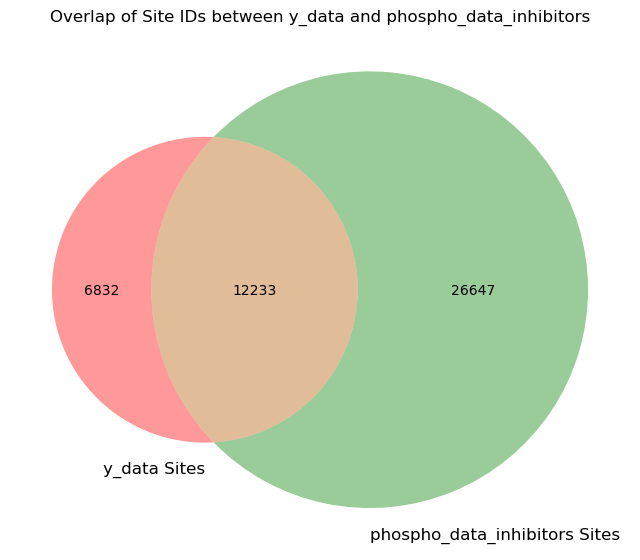

In [21]:
# Check the overlap of phosphosites between EGF timeseries and inhibitors data
sites_y = set(y_data.columns)
print("Number of sites in y_data:", len(sites_y))

sites_phospho = set(phospho_data_inhibitors['site_id'].unique())
print("Number of sites in phospho_data_inhibitors:", len(sites_phospho))

common_sites = sites_y.intersection(sites_phospho)
print("Number of common sites:", len(common_sites))

plt.figure(figsize=(8, 8))
venn_diagram = venn2([sites_y, sites_phospho], set_labels=('y_data Sites', 'phospho_data_inhibitors Sites'))
plt.title("Overlap of Site IDs between y_data and phospho_data_inhibitors")
plt.show()

# Keep only the common
y_data = y_data.loc[:, [col for col in y_data.columns if col in common_sites]]
phospho_data_inhibitors = phospho_data_inhibitors[phospho_data_inhibitors['site_id'].isin(common_sites)]

In [22]:
# Normalize the inhibitors data using the EGF data and their common biological condition: DMSO+EGF (done separately for R1 and R2)
egf_data_ref = y_data.loc[["EGF_R1_12", "EGF_R2_12"]].copy()
egf_data_ref = egf_data_ref.reset_index().rename(columns={'index':'Drug_CL_Time'})

egf_data_ref['Replicate'] = egf_data_ref['Drug_CL_Time'].apply(lambda x: x.split('_')[1])  
egf_data_ref = egf_data_ref.melt(id_vars=['Drug_CL_Time', 'Replicate'], 
                                  var_name='site_id', 
                                  value_name='egf_value')

phospho_ref = phospho_data_inhibitors[(phospho_data_inhibitors['Drug'] == 'DMSO-EGF') &
                                      (phospho_data_inhibitors['Time'] == '12')].copy()
phospho_ref['Time'] = phospho_ref['Time'].astype(str)

ref_merge = pd.merge(phospho_ref, egf_data_ref, left_on=['Replicate', 'site_id'],
                     right_on=['Replicate', 'site_id'], how='inner')
ref_merge['factor'] = ref_merge['egf_value'] - ref_merge['Value']

norm_factor = ref_merge.set_index(['site_id', 'Replicate'])['factor'].to_dict()

def apply_norm(row):
    key = (row['site_id'], row['Replicate'])
    if key in norm_factor:
        return row['Value'] + norm_factor[key]
    else:
        return row['Value']

phospho_data_inhibitors['Norm_Value'] = phospho_data_inhibitors.apply(apply_norm, axis=1)

phospho_data_inhibitors['Drug_CL_Time'] = phospho_data_inhibitors['Drug'] + '_' + \
                                          phospho_data_inhibitors['Replicate'] + '_' + \
                                          phospho_data_inhibitors['Time']
phospho_data_inhibitors.set_index('Drug_CL_Time', inplace=True)
phospho_data_inhibitors.drop(columns=['Drug', 'Replicate', 'Time'], inplace=True)

display(phospho_data_inhibitors.head())

,site_id,Value,Norm_Value
Drug_CL_Time,,,
DMSO_R1_12,1433E:P62258:S210s,0.030895,-0.055519
DMSO_R2_12,1433E:P62258:S210s,0.013333,0.157538
DMSO-EGF_R1_12,1433E:P62258:S210s,-0.020246,-0.106659
DMSO-EGF_R2_12,1433E:P62258:S210s,-0.407121,-0.262916
LY294002_R1_12,1433E:P62258:S210s,0.041171,-0.045243


In [23]:
phospho = phospho_data_inhibitors.copy()
phospho = phospho.drop(columns=['Value'])
phospho = phospho[~phospho.index.str.contains("DMSO-EGF")]  # filter out DMSO-EGF from inhibitors data

phospho_wide = phospho.reset_index()  
phospho_wide = phospho_wide.pivot(index='Drug_CL_Time', columns='site_id', values='Norm_Value')

all_times = y_data.index.str.split('_').str[-1].unique()
try:
    all_times = sorted(all_times, key=lambda t: int(t))
except Exception:
    all_times = sorted(all_times)

tmp = phospho_wide.reset_index()
tmp[['Base', 'Time']] = tmp['Drug_CL_Time'].str.rsplit('_', n=1, expand=True)
bases = tmp['Base'].unique()

new_idx = pd.MultiIndex.from_product([bases, all_times], names=['Base', 'Time'])

phospho_wide[['Base', 'Time']] = phospho_wide.index.to_series().str.rsplit('_', n=1, expand=True)
phospho_wide.index = pd.MultiIndex.from_arrays([phospho_wide['Base'], phospho_wide['Time']], names=['Base', 'Time'])
phospho_wide = phospho_wide.drop(columns=['Base', 'Time'])

# Reindex the DataFrame so every (Base, Time) combination appears (with missing values filled as NA)
phospho_expanded = phospho_wide.reindex(new_idx)

phospho_expanded = phospho_expanded.reset_index()
phospho_expanded['Drug_CL_Time'] = phospho_expanded['Base'] + '_' + phospho_expanded['Time']
phospho_expanded = phospho_expanded.set_index('Drug_CL_Time')
phospho_expanded = phospho_expanded.drop(columns=['Base', 'Time'])

combined_data = pd.concat([y_data, phospho_expanded], axis=0)
combined_data.head()

site_id,1433E:P62258:S210s,1433E:P62258:S233s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S45s,1433S:P31947:S63s,1433S:P31947:S64s,1433S:P31947:S69s,1433S:P31947:S74s,1433S:P31947:T90t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.361850,0.125242,-0.462252,0.005554,0.494495,-0.573325,-0.135045,-0.164306,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
EGF_R1_2,-0.540830,-0.032202,-0.622722,0.090442,-0.269800,0.022651,0.430511,-0.295428,-0.143599,0.124312,...,-1.191668,-0.689897,-0.355034,-1.742520,-1.768622,0.518072,-1.181069,-2.107800,-2.655664,-1.195930
EGF_R2_2,-0.215251,0.190632,0.074831,0.987148,0.312114,0.830756,0.796102,0.427318,0.503793,0.977873,...,-0.134774,-0.022878,-0.547265,-0.969857,-1.273527,-0.161955,-1.336020,-1.793863,-2.341803,-0.984556
EGF_R1_4,-0.170564,0.046843,0.334414,0.880003,0.025514,0.546906,0.678506,0.294914,0.405341,1.121505,...,-0.163212,-0.048941,-1.120298,-1.350231,-1.428485,-0.087478,-1.260146,-1.440121,-1.283719,-1.306305


In [24]:
combined_data_long = combined_data.reset_index().melt(
    id_vars="Drug_CL_Time",
    var_name="site_id",
    value_name="Value"
)
combined_data_long[['Drug', 'Cell_line', 'Time']] = combined_data_long['Drug_CL_Time'].str.split('_', expand=True)
combined_data_long = combined_data_long.drop(columns=["Drug_CL_Time"])

combined_data_long

,site_id,Value,Drug,Cell_line,Time
0,1433E:P62258:S210s,-0.246736,EGF,R1,0
1,1433E:P62258:S210s,-0.335641,EGF,R2,0
2,1433E:P62258:S210s,-0.540830,EGF,R1,2
3,1433E:P62258:S210s,-0.215251,EGF,R2,2
4,1433E:P62258:S210s,-0.170564,EGF,R1,4
...,...,...,...,...,...
1223295,ZYX:Q15942:Y172y,NaN,UO126,R2,0
1223296,ZYX:Q15942:Y172y,NaN,UO126,R2,2
1223297,ZYX:Q15942:Y172y,NaN,UO126,R2,4
1223298,ZYX:Q15942:Y172y,NaN,UO126,R2,8


In [25]:
combined_data_long = combined_data.reset_index().melt(
    id_vars="Drug_CL_Time",
    var_name="site_id",
    value_name="Value"
)
combined_data_long[['Drug', 'Cell_line', 'Time']] = combined_data_long['Drug_CL_Time'].str.split('_', expand=True)
combined_data_long = combined_data_long.drop(columns=["Drug_CL_Time"])

# Create dictionaries with the drug doses and drug targets
drug_dose = {'DMSO': 0, 'SHP099': -5, 'LY294002': -5, 'U0126': -5, 'SL0101': -5, 'EGF': 1}  # Negative for inhibitors
cell_lines = combined_data_long['Cell_line'].unique()
drug_dose = {(drug, cell_line): dose for drug, dose in drug_dose.items() for cell_line in cell_lines}  # same drug concentration for all cell lines

drug_targets = {
    "DMSO": [],  # control
    "EGF": ["P01133"],  # EGF (EGFR)
    "SHP099": ["Q06124"],  # PTPN11 (SHP2)
    "LY294002": ["P42336"],  # PIK3CA (PI3K)
    "U0126": ["Q02750", "P36507"],  # MAP2K1 (MEK1), MAP2K2 (MEK2)
    "SL0101": ["Q15418"]  # RPS6KA1 (RSK1)
}


# Prepare X_data
base_drugs = ['EGF', 'DMSO', 'LY294002', 'SHP099', 'SL0101', 'UO126']
unique_drug_cell_line = combined_data_long[['Drug', 'Cell_line']].drop_duplicates().sort_values(by=['Drug', 'Cell_line'])
index_names = unique_drug_cell_line.apply(lambda row: f"{row['Drug']}_{row['Cell_line']}", axis=1)
X_data = pd.DataFrame(0, index=index_names, columns=base_drugs)
X_data.index.name = 'Drug_CL'

for _, row in unique_drug_cell_line.iterrows():
    idx = f"{row['Drug']}_{row['Cell_line']}"
    drug_val = row['Drug']
    # If 'EGF' is present in the drug name add 1 under the EGF column.
    if "EGF" in drug_val:
        X_data.loc[idx, 'EGF'] = 1
    # For each inhibitor drug set its column to -5
    for inhibitor in ['LY294002', 'SHP099', 'SL0101', 'UO126']:
        if inhibitor in drug_val:
            X_data.loc[idx, inhibitor] = -5
    # DMSO rows remain at 0 (so no need to change)


# Prepare X_drug
unique_targets = sorted(set(target for targets in drug_targets.values() for target in targets))
X_drug = pd.DataFrame(0, index=unique_targets, columns=base_drugs)

for drug, targets in drug_targets.items():
    drug_col = 'UO126' if drug == 'U0126' else drug
    for target in targets:
        if target in X_drug.index:
            X_drug.loc[target, drug_col] = 1


# Prepare X_cell
X_cell = pd.DataFrame(index=multiindex)

unique_cell_lines = combined_data_long['Cell_line'].unique()
for cell_line in unique_cell_lines:
    X_cell[cell_line] = 0

for drug, cell_line in unique_drug_cell_line.itertuples(index=False):
    X_cell.loc[(drug, cell_line), cell_line] = 1

X_cell.index = X_cell.index.map('_'.join)
X_cell.index.name = 'Drug_CL'


# Prepare y_data
y_data = combined_data_long.pivot_table(index=['Drug', 'Cell_line', 'Time'], columns='site_id', values='Value')
y_data.reset_index(inplace=True)
y_data['Drug_CL_Time'] = y_data[['Drug', 'Cell_line', 'Time']].astype(str).agg('_'.join, axis=1)
y_data.set_index('Drug_CL_Time', inplace=True)

desired_times = [0, 2, 4, 8, 12]
y_data['Time'] = pd.to_numeric(y_data['Time'], errors='coerce')
unique_pairs = y_data[['Drug', 'Cell_line']].drop_duplicates()
times_df = pd.DataFrame({'Time': desired_times})
unique_pairs['key'] = 1
times_df['key'] = 1
cartesian = pd.merge(unique_pairs, times_df, on='key').drop('key', axis=1)
y_data_expanded = pd.merge(cartesian, y_data, on=['Drug', 'Cell_line', 'Time'], how='left')
y_data_expanded['Drug_CL_Time'] = y_data_expanded['Drug'] + '_' + y_data_expanded['Cell_line'] + '_' + y_data_expanded['Time'].astype(str)
y_data_expanded = y_data_expanded.set_index('Drug_CL_Time').drop(columns=['Drug', 'Cell_line', 'Time'])


# Prepare nodes_sites_map
unique_proteins = map_protein['protein_id'].unique()
unique_sites = map_protein['site_id'].unique()

nodes_sites_map = pd.DataFrame(0, index=unique_sites, columns=unique_proteins)

for _, row in map_protein.iterrows():
    site = row['site_id']
    protein = row['protein_id']
    if site in nodes_sites_map.index and protein in nodes_sites_map.columns:
        nodes_sites_map.loc[site, protein] = 1

# Sort and match index of nodes_sites_map with y_data
nodes_sites_map = nodes_sites_map.sort_index()
non_overlapping_values = set(nodes_sites_map.index).difference(y_data.columns)
nodes_sites_map = nodes_sites_map.drop(index=non_overlapping_values)

In [29]:
# Order Data
y_data_expanded = y_data_expanded[sorted(y_data_expanded.columns)]
temp = y_data_expanded.index.to_series().str.split('_', expand=True)
temp.columns = ['Drug', 'Cell_line', 'Time']
temp['Time'] = temp['Time'].astype(int)
y_data_expanded = y_data_expanded.loc[temp.sort_values(by=['Time','Drug','Cell_line']).index]

X_data = X_data.sort_index()
X_data = X_data[sorted(X_data.columns)]

X_cell = X_cell.sort_index()
X_cell = X_cell[sorted(X_cell.columns)]

X_drug = X_drug.sort_index()
X_drug = X_drug[sorted(X_drug.columns)]

nodes_sites_map = nodes_sites_map.sort_index()
nodes_sites_map = nodes_sites_map[sorted(nodes_sites_map.columns)]

display(X_data.head())
print(X_data.shape)

display(X_drug.head())
print(X_drug.shape)

display(X_cell.head())
print(X_cell.shape)

display(y_data_expanded.head())
print(y_data.shape)

display(nodes_sites_map.head())
print(nodes_sites_map.shape)

,DMSO,EGF,LY294002,SHP099,SL0101,UO126
Drug_CL,,,,,,
DMSO_R1,0,0,0,0,0,0
DMSO_R2,0,0,0,0,0,0
EGF_R1,0,1,0,0,0,0
EGF_R2,0,1,0,0,0,0
LY294002-EGF_R1,0,1,-5,0,0,0


(20, 6)


,DMSO,EGF,LY294002,SHP099,SL0101,UO126
P01133,0,1,0,0,0,0
P36507,0,0,0,0,0,1
P42336,0,0,1,0,0,0
Q02750,0,0,0,0,0,1
Q06124,0,0,0,1,0,0


(6, 6)


,R1,R2
Drug_CL,,
DMSO_R1,1.0,NaN
DMSO_R2,NaN,1.0
EGF_R1,1.0,0.0
EGF_R2,0.0,1.0
LY294002-EGF_R1,1.0,NaN


(20, 2)


,1433E:P62258:S210s,1433E:P62258:S233s,1433G:P61981:S71s,1433S:P31947:S209s,1433S:P31947:S45s,1433S:P31947:S63s,1433S:P31947:S64s,1433S:P31947:S69s,1433S:P31947:S74s,1433S:P31947:T90t,...,ZYX:Q15942:S15s,ZYX:Q15942:S206s,ZYX:Q15942:S259s,ZYX:Q15942:S267s,ZYX:Q15942:S281s,ZYX:Q15942:S303s,ZYX:Q15942:S308s,ZYX:Q15942:S344s,ZYX:Q15942:T270t,ZYX:Q15942:Y172y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
DMSO_R1_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DMSO_R2_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EGF_R1_0,-0.246736,0.077428,0.277434,0.729609,0.199510,0.094034,0.690117,0.277045,0.300236,0.620508,...,-0.683983,-0.072105,-0.363885,-1.527132,-1.502397,0.035326,-1.063139,-1.795758,-2.589777,-1.254589
EGF_R2_0,-0.335641,-0.352439,-0.361850,0.125242,-0.462252,0.005554,0.494495,-0.573325,-0.135045,-0.164306,...,-1.681634,-0.154056,-0.045588,-1.714333,-1.979430,0.032173,-1.271806,-2.007758,-2.516158,-1.335665
LY294002_R1_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(28, 12236)


,A0MZ66,A1A4S6,A1L390,A1X283,A2RUS2,A6H8Y1,A6ND36,A7KAX9,A7MBM2,A7MCY6,...,Q9Y6M7,Q9Y6N7,Q9Y6Q6,Q9Y6Q9,Q9Y6R0,Q9Y6R4,Q9Y6W5,Q9Y6X0,Q9Y6X2,Q9Y6Y8
1433E:P62258:S210s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433E:P62258:S233s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433G:P61981:S71s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S209s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433S:P31947:S45s,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(12233, 2603)


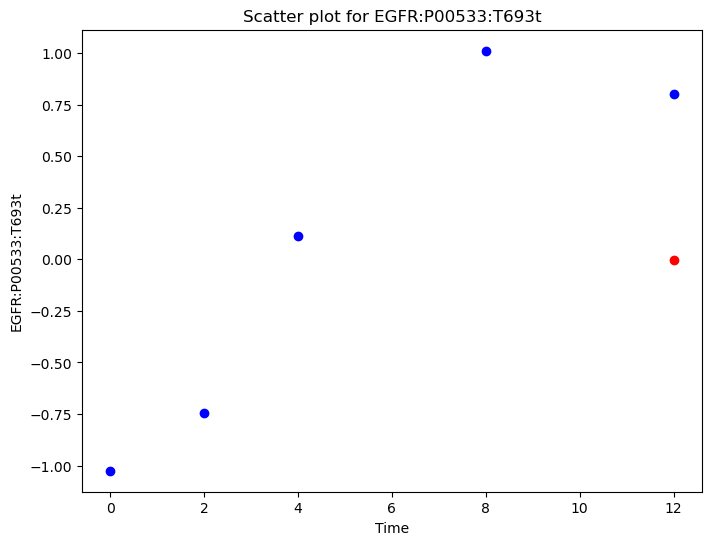

In [27]:
subset_egf = y_data[y_data.index.str.startswith("EGF_R2_")].copy()
subset_u0126 = y_data[y_data.index == "SHP099-EGF_R1_12"].copy()
col_target = "EGFR:P00533:T693t"

subset_egf = subset_egf[[col_target]]
subset_u0126 = subset_u0126[[col_target]]
subset_egf['Time'] = subset_egf.index.str.split('_').str[-1].astype(float)
subset_u0126['Time'] = subset_u0126.index.str.split('_').str[-1].astype(float)

plt.figure(figsize=(8,6))
plt.scatter(subset_egf['Time'], subset_egf[col_target], color='blue', label='EGF_R1 (all times)')
plt.scatter(subset_u0126['Time'], subset_u0126[col_target], color='red', label='U0126_R1_12')
plt.xlabel("Time")
plt.ylabel(col_target)
plt.title(f"Scatter plot for {col_target}")
plt.show()

### Export Data

In [28]:
y_data_expanded.to_csv('../data/egf_y_all.csv', index=True)
X_data.to_csv('../data/egf_x_all.csv', index=True)
X_cell.to_csv('../data/egf_xcell_all.csv', index=True)
X_drug.to_csv('../data/egf_xdrug_all.csv', index=True)
nodes_sites_map.to_csv('../data/egf_nodes_sites_map_all.csv', index=True)